In [1]:
# Loading Dataframe and dropping duplicates and id column
import pandas as pd


df_train = pd.read_csv('/content/drive/MyDrive/MV Stat/loan_sanction_train.csv')
df_train.drop_duplicates(inplace=True)
df_train.drop('Loan_ID', axis=1, inplace=True)

In [ ]:
# Data Cleaning and Data manipulation: fillna and median/mode imputation
df_train.dropna(subset=['Married', 'Gender'], inplace=True)
df_train['Dependents'].fillna('Unknown', inplace=True)
df_train['Self_Employed'].fillna('Unknown', inplace=True)
df_train['Credit_History'].fillna('Unknown', inplace=True)
df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mode()[0], inplace=True)
df_train['LoanAmount'].fillna(df_train['LoanAmount'].median(), inplace=True)

In [3]:
# value counts for dependent variable shows moderate imbalnce towards the positive class
print(df_train['Loan_Status'].value_counts())


Loan_Status
Y    411
N    187
Name: count, dtype: int64


In [5]:
# one-hot encode categorical variables to booolean values for predictions
df_train = pd.get_dummies(df_train, drop_first=True)

In [6]:
list(df_train.columns)

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Gender_Male',
 'Married_Yes',
 'Dependents_1',
 'Dependents_2',
 'Dependents_3+',
 'Dependents_Unknown',
 'Education_Not Graduate',
 'Self_Employed_Unknown',
 'Self_Employed_Yes',
 'Credit_History_1.0',
 'Credit_History_Unknown',
 'Property_Area_Semiurban',
 'Property_Area_Urban',
 'Loan_Status_Y']

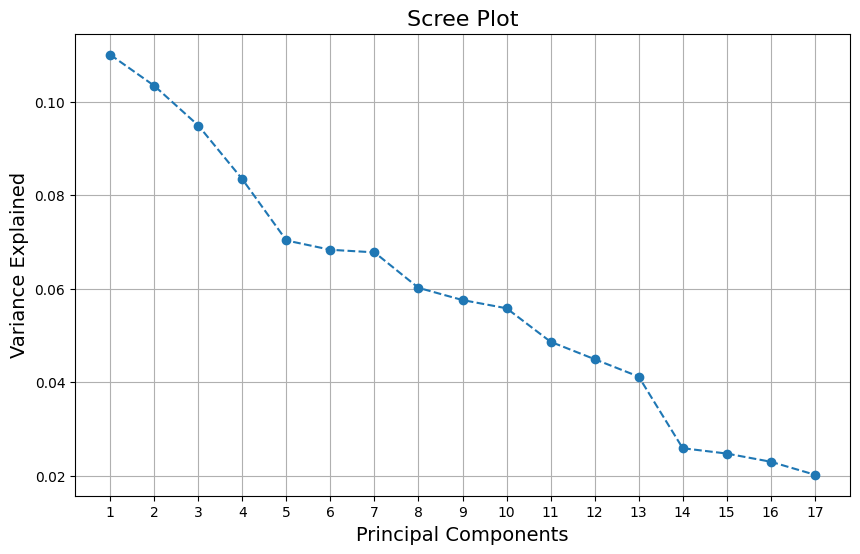

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_train.drop('Loan_Status_Y', axis=1)
y = df_train['Loan_Status_Y']


# Split into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, random_state=42, stratify=y
)

# Standardize for PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Implement PCA for Screeplot
pca = PCA()
pca.fit(X_train_scaled)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Elbowplot
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(explained_variance) + 1),
         explained_variance,
         marker='o', linestyle='--')
plt.title('Scree Plot', fontsize=16)
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained', fontsize=14)
plt.xticks(np.arange(1, len(explained_variance)+1))  # Show all PCs on x-axis
plt.grid(True)
plt.show()



In [10]:
# Tells us how many components to keep for explaining 85% of the data
from sklearn.decomposition import PCA
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"Number of components to retain ~85% variance: {n_components_85}")

#12 PCs retained 85% variability

Number of components to retain ~85% variance: 12


In [17]:
# Implement PCA using only 12 PCs
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)

# Get the coefficients from LDA
lda_coefficients = lda.coef_[0]

# Create a table showing importance of each PC
pc_importance = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(lda_coefficients))],
    'LDA Coefficient': lda_coefficients
})

# Sort by most important first
pc_importance['Importance'] = pc_importance['LDA Coefficient'].abs()
pc_importance = pc_importance.sort_values('Importance', ascending=False)


# Train Random Forest on PCA-transformed features
rf = RandomForestClassifier(n_estimators=100, random_state=42) #using default parameters for simplicity
rf.fit(X_train_pca, y_train)

# Get feature importances from the Random Forest model
rf_importances = rf.feature_importances_

# Create a table showing importance of each PC
pc_importance_rf = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(rf_importances))],
    'Feature Importance': rf_importances
})


# Sort by highest importance
pc_importance_rf = pc_importance_rf.sort_values('Feature Importance', ascending=False)

print(pc_importance_rf)
print(pc_importance)

   Principal Component  Feature Importance
1                  PC2            0.112089
6                  PC7            0.105185
0                  PC1            0.099007
8                  PC9            0.084626
5                  PC6            0.081921
2                  PC3            0.078489
7                  PC8            0.076990
3                  PC4            0.076142
11                PC12            0.075553
10                PC11            0.072334
9                 PC10            0.071057
4                  PC5            0.066607
   Principal Component  LDA Coefficient  Importance
1                  PC2        -0.299868    0.299868
11                PC12        -0.296081    0.296081
6                  PC7         0.261844    0.261844
0                  PC1        -0.250450    0.250450
2                  PC3         0.245208    0.245208
5                  PC6        -0.202432    0.202432
9                 PC10        -0.085058    0.085058
7                  PC8   

In [16]:
# Create the loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,  # Take transpose so features are rows
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X_train.columns  # original feature names (before PCA transform)
)
# Get top loadings for PC2
top_features_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(5)
print("Top 5 Features contributing to PC2:\n")
print(top_features_pc2)

# Get top loadings for PC7
top_features_pc7 = loadings['PC7'].abs().sort_values(ascending=False).head(5)
print("\nTop 5 Features contributing to PC7:\n")
print(top_features_pc7)


Top 5 Features contributing to PC2:

Property_Area_Urban        0.418080
LoanAmount                 0.407713
ApplicantIncome            0.392642
Property_Area_Semiurban    0.386971
Credit_History_1.0         0.313742
Name: PC2, dtype: float64

Top 5 Features contributing to PC7:

Self_Employed_Unknown    0.463338
CoapplicantIncome        0.369664
Credit_History_1.0       0.355482
Self_Employed_Yes        0.340648
Loan_Amount_Term         0.326718
Name: PC7, dtype: float64


In [14]:
# Get predicted probabilities for class 1 (Approved/low risk)
y_val_proba_lda = lda.predict_proba(X_val_pca)[:,1]

# Set new threshold to make model classify a positive instance ONLY if the predicted probability is 0.65 or greater
threshold = 0.65
y_val_pred_lda = (y_val_proba_lda >= threshold).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Evaluate
print("LDA_Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_lda))
print(f"Precision: {precision_score(y_val, y_val_pred_lda):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_lda):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred_lda):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_lda):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba_lda):.4f}")


LDA_Confusion Matrix:
 [[18 20]
 [15 67]]
Precision: 0.7701
Recall: 0.8171
F1 Score: 0.7929
Accuracy: 0.7083
ROC AUC: 0.7105


In [15]:
# Get predicted probabilities for class 1 (Approved/low risk)
y_val_proba_rf = rf.predict_proba(X_val_pca)[:,1]

# Set new threshold to make model classify a positive instance ONLY if the predicted probability is 0.65 or greater
threshold = 0.65
y_val_pred_rf_thresh = (y_val_proba_rf >= threshold).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Evaluate
print("RF_Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf_thresh))
print(f"Precision: {precision_score(y_val, y_val_pred_rf_thresh):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_rf_thresh):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred_rf_thresh):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf_thresh):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_proba_rf):.4f}")



RF_Confusion Matrix:
 [[25 13]
 [18 64]]
Precision: 0.8312
Recall: 0.7805
F1 Score: 0.8050
Accuracy: 0.7417
ROC AUC: 0.7518


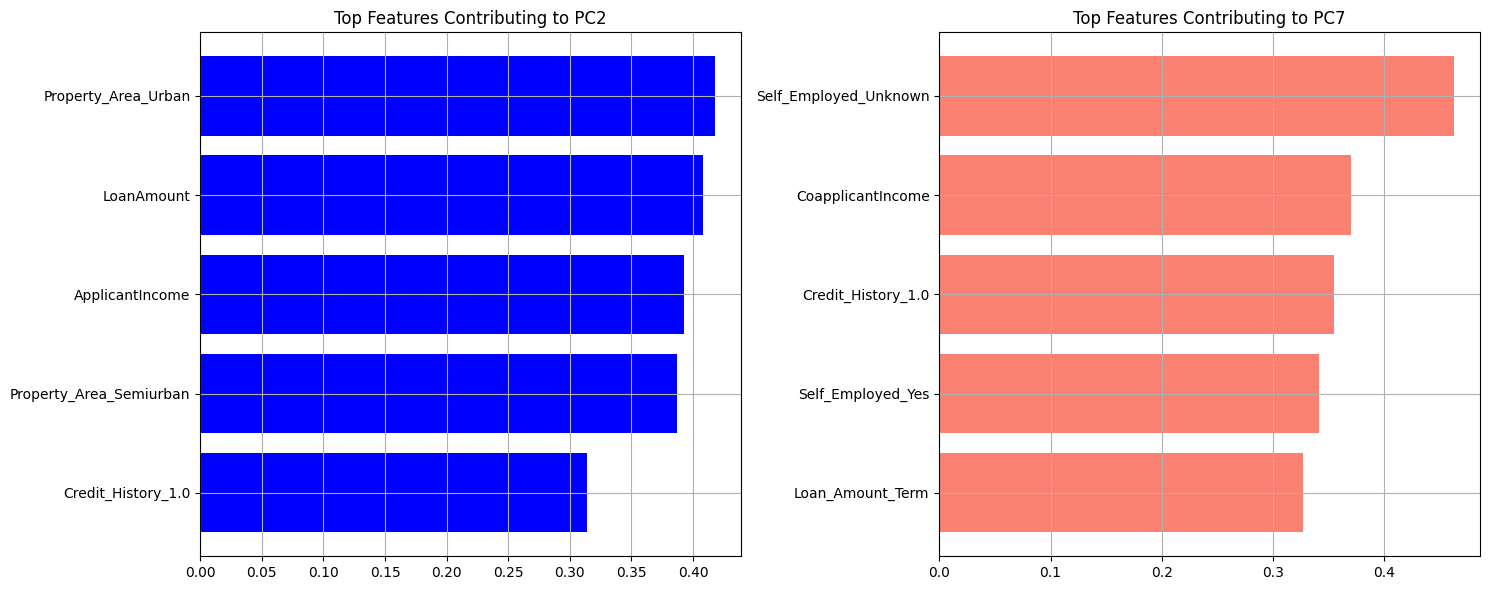

In [ ]:
import matplotlib.pyplot as plt

# Top features for PC2
top_features_pc2 = {
    'Property_Area_Urban': 0.418,
    'LoanAmount': 0.408,
    'ApplicantIncome': 0.393,
    'Property_Area_Semiurban': 0.387,
    'Credit_History_1.0': 0.314
}

# Top features for PC7
top_features_pc7 = {
    'Self_Employed_Unknown': 0.463,
    'CoapplicantIncome': 0.370,
    'Credit_History_1.0': 0.355,
    'Self_Employed_Yes': 0.341,
    'Loan_Amount_Term': 0.327
}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))

# PC2
axes[0].barh(list(top_features_pc2.keys()), list(top_features_pc2.values()), color='blue')
axes[0].set_title('Top Features Contributing to PC2')
axes[0].invert_yaxis()
axes[0].grid(True)

# PC7
axes[1].barh(list(top_features_pc7.keys()), list(top_features_pc7.values()), color='salmon')
axes[1].set_title('Top Features Contributing to PC7')
axes[1].invert_yaxis()
axes[1].grid(True)

plt.tight_layout()
plt.show()


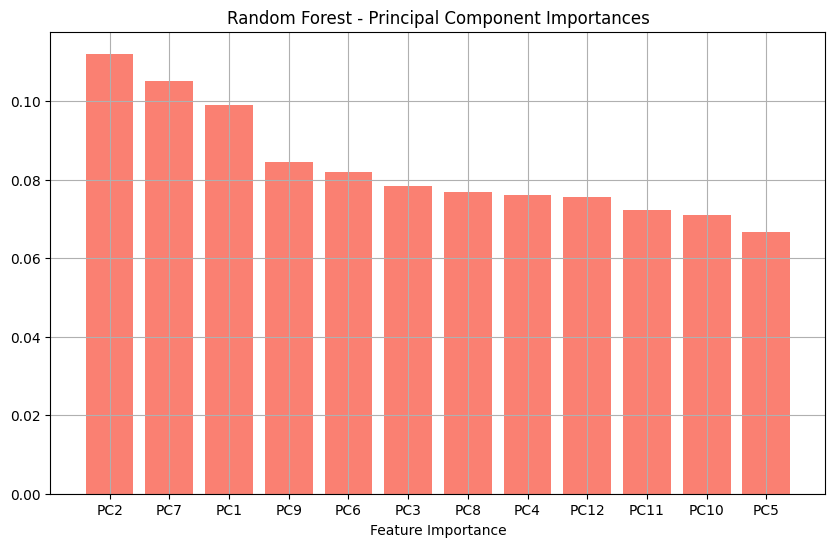

In [ ]:
# Plts feauture importance for the random forest model
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(pc_importance_rf['Principal Component'], pc_importance_rf['Feature Importance'], color='salmon')
plt.xlabel('Feature Importance')
plt.title('Random Forest - Principal Component Importances')
plt.grid(True)
plt.show()

# pc2, pc7, and pc1 were top contribitors

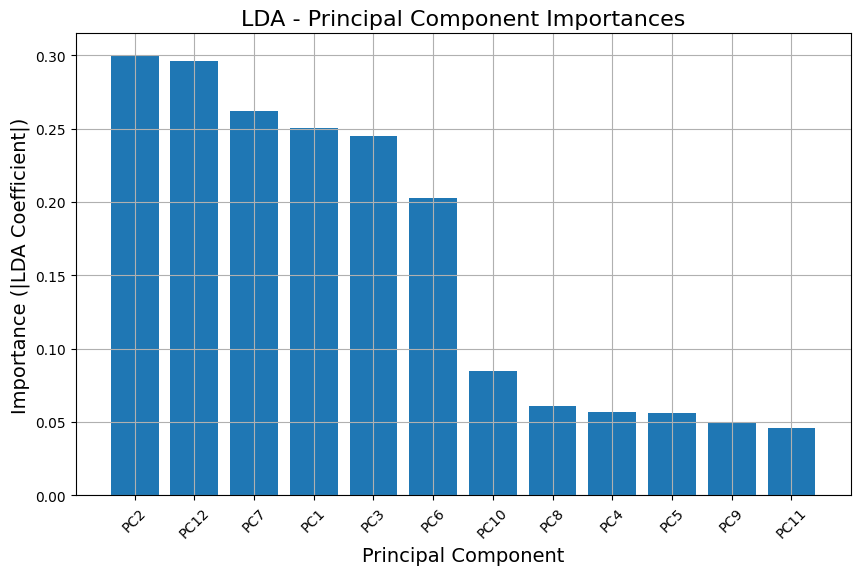

In [ ]:
# Plotting feature importance for LDA
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(pc_importance['Principal Component'], pc_importance['Importance'])
plt.title('LDA - Principal Component Importances', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Importance (|LDA Coefficient|)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#PC2, PC12, and PC7 were the most impactful predictors


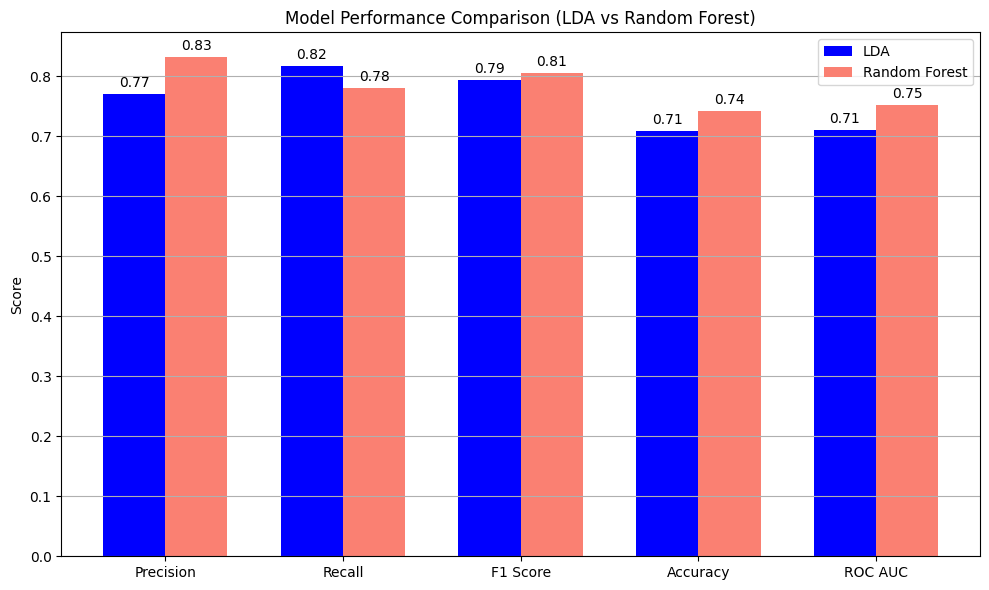

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'ROC AUC']

lda_scores = [0.7701, 0.8171, 0.7929, 0.7083, 0.7105]
rf_scores = [0.8312, 0.7805, 0.8050, 0.7417, 0.7518]

# Set up bar locations
x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width/2, lda_scores, width, label='LDA', color='blue')
rects2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest', color='salmon')

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (LDA vs Random Forest)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y')

# Add numerical labels above bars
ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()


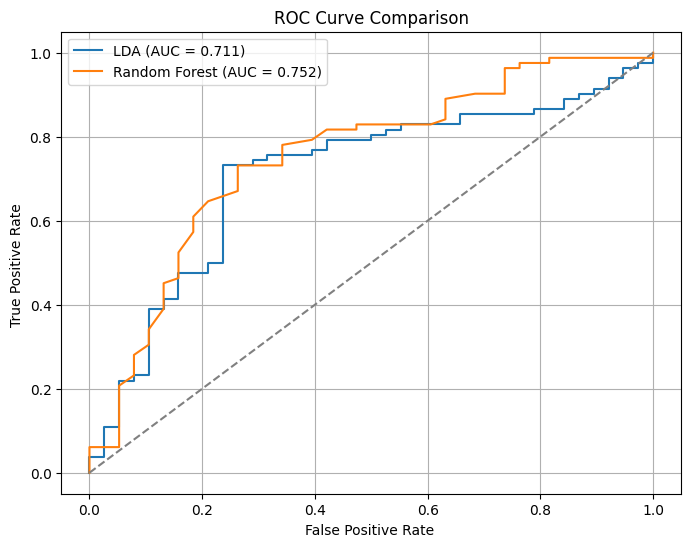

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get probability estimates for class 1 (Approved) for both models
y_val_proba_lda = lda.predict_proba(X_val_pca)[:, 1]
y_val_proba_rf = rf.predict_proba(X_val_pca)[:, 1]

# Calculate ROC curve points
fpr_lda, tpr_lda, _ = roc_curve(y_val, y_val_proba_lda)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)

# Calculate AUC scores
auc_lda = roc_auc_score(y_val, y_val_proba_lda)
auc_rf = roc_auc_score(y_val, y_val_proba_rf)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {auc_lda:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # reference line (random)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.legend()
plt.grid(True)
plt.show()


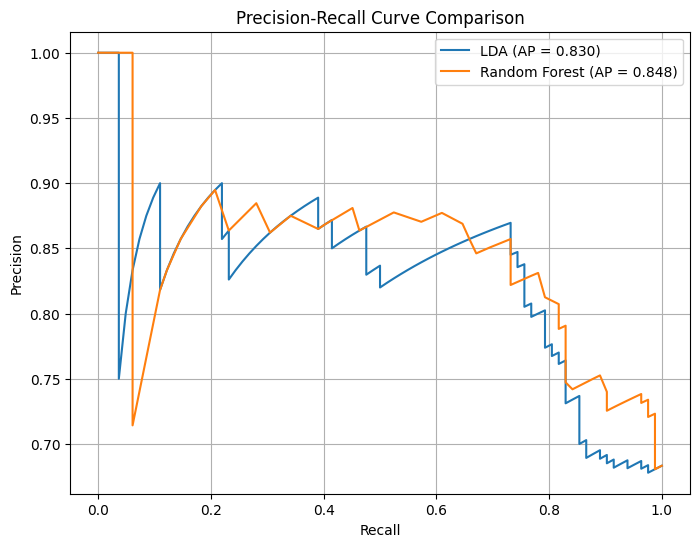

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get probability estimates again
y_val_proba_lda = lda.predict_proba(X_val_pca)[:, 1]
y_val_proba_rf = rf.predict_proba(X_val_pca)[:, 1]

# Precision-Recall points
precision_lda, recall_lda, _ = precision_recall_curve(y_val, y_val_proba_lda)
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_val_proba_rf)

# Average Precision Scores (area under Precision-Recall curve)
ap_lda = average_precision_score(y_val, y_val_proba_lda)
ap_rf = average_precision_score(y_val, y_val_proba_rf)

# Plot Precision-Recall curves
plt.figure(figsize=(8,6))
plt.plot(recall_lda, precision_lda, label=f'LDA (AP = {ap_lda:.3f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.3f})')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()
